In [12]:
!pip install pyspark

In [13]:
import numpy as np
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql.functions import sum, col, desc
from pyspark.sql.types import *

In [14]:
session = SparkSession.builder.master("local").appName("Dataframes").getOrCreate()

In [15]:
data_path = "/content/nf2.json"

In [16]:
df = session.read.json(data_path, multiLine=True)

In [17]:
df.show(10)

+--------------------+--------------------+------------------+--------------------+---------+--------------------+------+------------+-------+--------------------+-------+
|                cast|             country|        date_added|            director| duration|           listed_in|rating|release_year|show_id|               title|   type|
+--------------------+--------------------+------------------+--------------------+---------+--------------------+------+------------+-------+--------------------+-------+
|                    |       United States|September 25, 2021|     Kirsten Johnson|   90 min|       Documentaries| PG-13|        2020|     s1|Dick Johnson Is Dead|  Movie|
|Ama Qamata, Khosi...|        South Africa|September 24, 2021|                    |2 Seasons|International TV ...| TV-MA|        2021|     s2|       Blood & Water|TV Show|
|Sami Bouajila, Tr...|                    |September 24, 2021|     Julien Leclercq| 1 Season|Crime TV Shows, I...| TV-MA|        2021|     s

Most frequent actor in the database

In [18]:
from pyspark.sql.functions import col, explode, split
# Check if "actor" column exists in the DataFrame
if "actor" in df.columns:
    actor_column = "actor"
elif "cast" in df.columns:
    actor_column = "cast"
else:
    raise ValueError("No column found containing actor information.")
# Split the string by commas and explode to separate actors
actor_counts = df.filter(col(actor_column) != "") \
      .select(explode(split(col(actor_column), ",\s*")).alias("actor")) \
      .groupBy("actor").count().orderBy(col("count").desc())
# Take the actor with the highest count
most_common_actor = actor_counts.first()["actor"]

print("The actor that appears most often is:", most_common_actor)

The actor that appears most often is: Anupam Kher


Most popular movie genre excluding TV series

In [19]:
from pyspark.sql.functions import explode, split
# Step 1: Filter to include only movies
movies_df = df.filter(df.type == "Movie")

# Step 2: Explode the "listed_in" column to split genres
genres_df = movies_df.select(explode(split(df.listed_in, ",\s*")).alias("genre"))

# Step 3: Group by genre and count occurrences, then sort by count
genre_counts = genres_df.groupBy("genre").count().orderBy("count", ascending=False)

# Step 4: Take the most popular genre
most_popular_genre = genre_counts.first()["genre"]

print("The most popular genre among movies is:", most_popular_genre)


The most popular genre among movies is: International Movies


Appearance graph of the most popular actor

In [20]:
import matplotlib.pyplot as plt

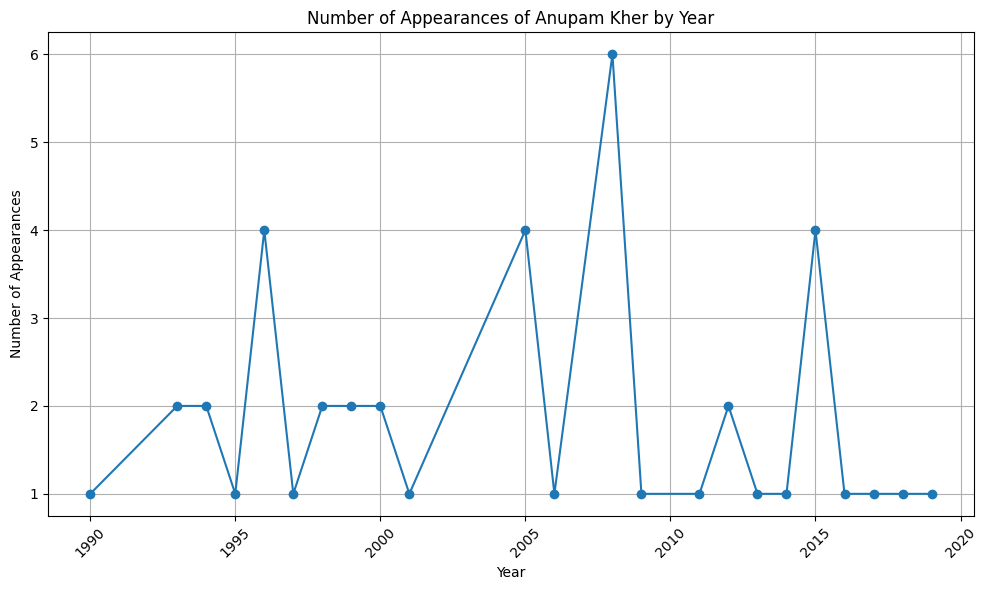

In [21]:
from pyspark.sql.functions import explode, split, col
import matplotlib.pyplot as plt

# Explode the "cast" column to get individual actors
actors_df = df.filter(col("cast") != "") \
    .select(explode(split(col("cast"), ",\s*")).alias("actor"), "release_year")

# Group by actor and release year, then count appearances
actor_year_counts = actors_df.groupBy("actor", "release_year").count()

# Calculate the total appearances for each actor
actor_total_counts = actor_year_counts.groupBy("actor").sum("count")

# Find the most popular actor with the highest total count of appearances
most_popular_actor = actor_total_counts.orderBy("sum(count)", ascending=False).first()[0]

# Filter the DataFrame to include only the most popular actor
most_popular_actor_df = actor_year_counts.filter(col("actor") == most_popular_actor)

# Extract data for plotting
years = most_popular_actor_df.select("release_year").distinct().orderBy("release_year").rdd.flatMap(lambda x: x).collect()
appearances = most_popular_actor_df.select("count").rdd.flatMap(lambda x: x).collect()

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(years, appearances, marker='o', linestyle='-')
plt.title(f"Number of Appearances of {most_popular_actor} by Year")
plt.xlabel("Year")
plt.ylabel("Number of Appearances")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Graph of the most popular words

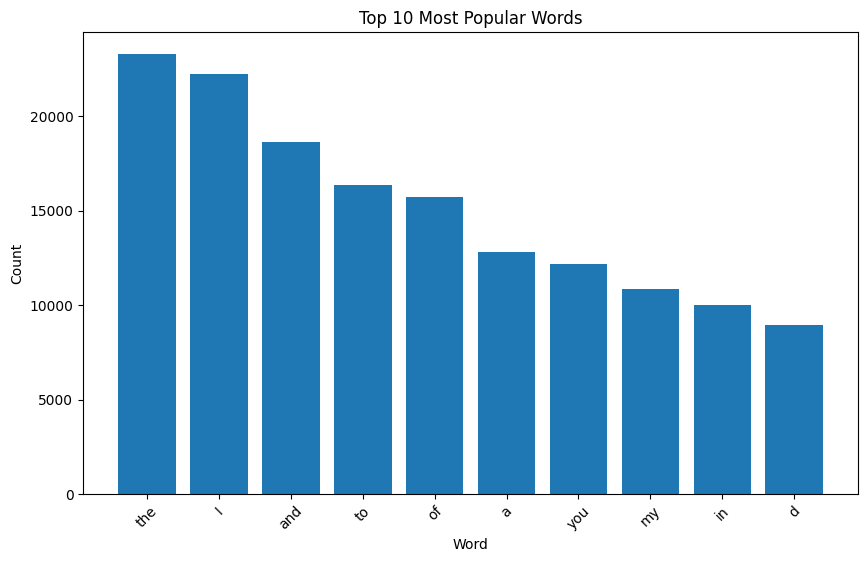

In [22]:
from pyspark.sql import SparkSession

# Initialize Spark session
spark = SparkSession.builder \
    .appName("WordCount") \
    .getOrCreate()

# Load the text file containing word counts
file_content = spark.sparkContext.textFile("/content/popular_words.txt")

# Split the content into lines
lines = file_content.flatMap(lambda text: text.split("\n"))

# Split each line into word and count
words_counts = lines.map(lambda line: line.split(":"))

# Convert RDD to DataFrame
df = words_counts.toDF(["Word", "Count"])

# Convert count column to integer type
df = df.withColumn("Count", df["Count"].cast("int"))

# Select top 10 most popular words
top_10_words_df = df.orderBy(df["Count"].desc()).limit(10)

# Convert DataFrame to Pandas DataFrame
top_10_words_pd = top_10_words_df.toPandas()

# Plot the top 10 most popular words
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(top_10_words_pd["Word"], top_10_words_pd["Count"])
plt.xlabel("Word")
plt.ylabel("Count")
plt.title("Top 10 Most Popular Words")
plt.xticks(rotation=45)
plt.show()